# シナプス結合強度の不均一性
(概要)
シナプス結合強度は正規分布に従わず，対数正規分布のような裾の重い分布 (heavy-tailed distribution) に従う．すなわち，多くの弱いシナプス結合と少数の強いシナプス結合が存在する．これは電気生理学的なEPSP (シナプス後電位) の測定や電子顕微鏡によるコネクトームの解析により明らかになっている．

本章では (Lynn, Holmes & Palmer, Nature Physics. 2024) で提案された，シナプス結合が裾の重い分布に従うネットワークを生成する発達モデルを紹介する．

コードに関しては <https://github.com/ChrisWLynn/Heavy_tailed_connectivity> を参考に作成した．

In [1]:
using PyPlot, Random, Distributions, LinearAlgebra, StatsBase
using ProgressMeter
using Graphs, GraphPlot
using SpecialFunctions
rc("axes.spines", top=false, right=false)

まず，活動に非依存的なモデルを紹介する．このモデルではネットワーク全体のシナプス結合強度の和 ($S$) が一定になるようにシナプスの枝刈りと2通りの増強を行う．

枝刈りの過程ではシナプスの結合強度に「よらず」，一様にシナプスが選択されて枝刈りされる．その際に減少した結合強度分を次のように他のシナプス結合に付与する．
確率 $p$ でシナプス結合強度に応じた確率でシナプスを選択し，増強する．確率 $1-p$ でランダムなシナプスを増強する．前者の過程により，強いシナプス結合はより増強される (The rich get richer)．

In [2]:
function generate_scale_free_network(;
        N=200, s_avg=1, p=0.5, num_iter=1000,
        num_prune_edge=50, activity_depend=true, β=0.8)
    # set params
    num_max_edge = N * (N - 1)
    S = s_avg * num_max_edge

    # initialization
    edge_indices = findall((ones(Int64, N, N) - I(N)) .== 1);
    indices_sample = sample(1:num_max_edge, S, replace=false);
    A = zeros(N, N);
    A[edge_indices[indices_sample]] .= 1;

    @showprogress for t in 1:num_iter
        # pruning
        prune_indices = sample(1:num_max_edge, num_prune_edge, replace=false)
        ΔS = Int(sum(A[edge_indices[prune_indices]]))
        A[edge_indices[prune_indices]] .= 0;
        
        # hebbian update
        ΔS_hebb = Int(sum(rand(Binomial(1, p), ΔS)))
        if activity_depend
            A_norm = A / (s_avg*N);
            x = fixed_point(f, -ones(N), args=(A_norm, β), method="iteration");
            D = diagm(1 .- x.^2);
            C = β*((I - β * D * A_norm) \ D);
            hebb_indices = sample(1:num_max_edge, Weights(C[edge_indices]), ΔS_hebb, replace=false)
        else
            hebb_indices = sample(1:num_max_edge, Weights(A[edge_indices]), ΔS_hebb, replace=false)
        end
        # random update
        ΔS_rand = ΔS - ΔS_hebb
        rand_indices = sample(1:num_max_edge, ΔS_rand, replace=false);
        
        growth_indices = [hebb_indices; rand_indices]
        A[edge_indices[growth_indices]] .+= 1;
    end

    A_flat = vcat(A[edge_indices]...);
    order_dict = sort(countmap(A_flat));
    order_arr = hcat(collect(keys(order_dict)), collect(values(order_dict)));
    order_arr[:, 2] ./= S;
    return A, A_flat, order_arr
end

generate_scale_free_network (generic function with 1 method)

ニューロン数 ($N=20$) でグラフを描画しよう．少数の強い結合が存在していることが分かる．

In [13]:
A_small, A_small_flat, _ = generate_scale_free_network(;N=20, s_avg=1, p=0.5, num_iter=1000, num_prune_edge=10);

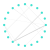

In [14]:
g = SimpleGraph(A_small + A_small')
gplot(g, layout=circular_layout, edgelinewidth=A_small_flat, plot_size=(5cm,5cm))

ニューロン数を ($N=200$) に増やし，各結合強度の出現頻度を描画しよう．

In [39]:
p = 0.5
s_avg = 1
N = 100
A, _, order_arr = generate_scale_free_network(N=N, s_avg=s_avg, p=p, num_iter=4000, num_prune_edge=100);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


各結合強度の出現頻度を予測する理論的式は以下で与えられる．

In [16]:
P(s, s_avg, p) = gamma(s + s_avg * (1/p - 1)) / gamma(s + s_avg * (1/p - 1) + 1/p + 1)

P (generic function with 1 method)

In [17]:
s_arr = exp10.(range(1e-8, stop=2, length=40));
#s_arr = range(1, stop=100, length=400);
P_arr = P.(s_arr, s_avg, p);
P_arr ./= sum(P_arr);#$(40 / length(s_arr));

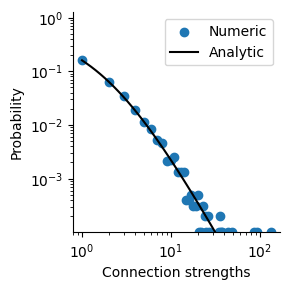

In [41]:
figure(figsize=(3,3))
scatter(order_arr[:, 1], order_arr[:, 2], label="Numeric")
plot(s_arr, P_arr, c="k", label="Analytic")
xscale("log")
yscale("log")
legend()
ylim(minimum(order_arr[:, 2]), )
xlabel("Connection strengths")
ylabel("Probability")
tight_layout()

#hist(A_flat, bins=exp10.(range(0,stop=2,length=10)), log=true, density=true);
#xscale("log")

In [35]:
# based on scipy.fixed_point()
function fixed_point(func, x0; args=(), tol=1e-6, max_iter=100, method="del2")
    p0 = x0
    Δp = nothing
    for i in 1:max_iter
        p1 = func(p0, args...)
        if method == "del2"
            # Steffensen's Method with Aitken's Δ²
            p2 = func(p1, args...)
            p = p0 - (p1 - p0) .^2 ./ (p2 - 2 * p1 + p0)
        else
            p = p1
        end
        Δp = maximum(abs.(p .- p0))
        if Δp < tol
            return p
        end
        p0 = p
    end
    error("Failed to converge after $max_iter iterations. Δp=$Δp")
end;

In [36]:
f(x, A, β) = tanh.(β * A * x)

f (generic function with 1 method)

generate_scale_free_network2 (generic function with 1 method)

In [42]:
p = 0.5
s_avg = 1
A2, _, order_arr2 = generate_scale_free_network2(N=N, s_avg=s_avg, p=p, num_iter=4000, num_prune_edge=100);

Progress: 100%|█████████████████████████████████████████| Time: 0:01:05


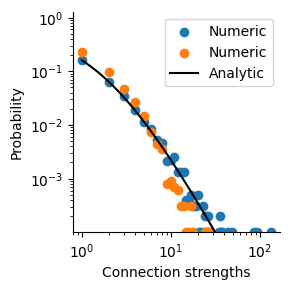

In [43]:
figure(figsize=(3,3))
scatter(order_arr[:, 1], order_arr[:, 2], label="Numeric")
scatter(order_arr2[:, 1], order_arr2[:, 2], label="Numeric")
plot(s_arr, P_arr, c="k", label="Analytic")
xscale("log")
yscale("log")
legend()
ylim(minimum(order_arr[:, 2]), )
xlabel("Connection strengths")
ylabel("Probability")
tight_layout()

#hist(A_flat, bins=exp10.(range(0,stop=2,length=10)), log=true, density=true);
#xscale("log")